# IQ TEST SEQUENCER BOT - RNN TEST

In [118]:
# Imports
import pandas as pd
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense
import random
from keras.layers import Bidirectional
from matplotlib import pyplot

## Read in the data

In [10]:
seqdataIn = pd.read_json('data/seq-public.json', orient='records')
print(seqdata)

                  stem               options            category    id
0           7,9,-1,5,?        [4, 2, -1, -3]            sequence     0
1        3,2,5/3,3/2,?  [1/4, 7/5, 3/4, 2/5]            sequence     1
2           1,2,5,26,?    [34, 841, 677, 37]            sequence     2
3            2,12,30,?      [50, 65, 75, 56]            sequence     3
4        2,1,2/3,1/2,?  [3/4, 1/4, 2/5, 5/6]            sequence     4
...                ...                   ...                 ...   ...
1071  20 22 25 30 37 ?                    []  sequence-reasoning  1090
1072        0 1 3 10 ?                    []  sequence-reasoning  1091
1073       5 15 10 215                    []  sequence-reasoning  1092
1074        1 2 5 29 ?    [34, 841, 866, 37]  sequence-reasoning  1093
1075         2 12 30 ?      [50, 65, 75, 56]  sequence-reasoning  1094

[1076 rows x 4 columns]


In [181]:
seqDataAns =pd.read_json('data/seq-public.answer.json',orient='index')
print(seqDataAns)

     answer                                               hint
0       [4]      A<sub>n+1</sub>=2<sup>5-n</sup>-A<sub>n</sub>
1       [2]  3/1, 4/2, 5/3, 6/4\n\nA<sub>n+1</sub>=A<sub>n<...
2       [3]        A<sub>n+1</sub>=A<sub>n</sub><sup>2</sup>+1
3       [4]                           A<sub>n</sub>=2n\*(2n-1)
4       [3]             4/2, 4/4, 4/6, 4/8\n\nA<sub>n</sub>=2n
...     ...                                                ...
1090     48                A<sub>n+1</sub>-A<sub>n</sub>=P(n);
1091    102           A<sub>n\*2</sub>=A<sub>n\*2-1</sub>^2+2;
1092   -115   A<sub>n</sub>=A<sub>n-2</sub>^2-A<sub>n-1</sub>;
1093    [3]  A<sub>n</sub>=A<sub>n-1</sub>^2+A<sub>n-2</sub...
1094    [4]                      A<sub>n</sub>=(2\*n-1)\*2\*n;

[1076 rows x 2 columns]


####  Preprocess hints for printing - (not given with question)

In [182]:
def hint2txt(h):
    return h.replace('<sub>','_{').replace('</sub>','}').replace('<sup>','^{').replace('</sup>','}').replace('\n',' | ').replace('\*','*')
seqDataAns['hint'] = seqDataAns['hint'].map(lambda x: hint2txt(x))
print(seqDataAns['hint'])

0                                   A_{n+1}=2^{5-n}-A_{n}
1       3/1, 4/2, 5/3, 6/4 |  | A_{n+1}=A_{n}+1 |  | B...
2                                     A_{n+1}=A_{n}^{2}+1
3                                         A_{n}=2n*(2n-1)
4                        4/2, 4/4, 4/6, 4/8 |  | A_{n}=2n
                              ...                        
1090                                  A_{n+1}-A_{n}=P(n);
1091                               A_{n*2}=A_{n*2-1}^2+2;
1092                             A_{n}=A_{n-2}^2-A_{n-1};
1093                           A_{n}=A_{n-1}^2+A_{n-2}^2;
1094                                   A_{n}=(2*n-1)*2*n;
Name: hint, Length: 1076, dtype: object


#### NOTE: The sequences are recursive and can involve exponents and the index number. 
#### The answers also correspond to the index in the answer choices not the literal answer

## Fibonacci LSTM Test

In [35]:
#define fibonacci function
def fib(x):
    if x == 0:
        return 1
    elif x == 1:
        return 1
    else:
        return fib(x-1)+fib(x-2)

#returns n fibonacci numbers (starting with the 'start'th number) 
def fibSeq(n,start=0):
    s = []
    for i in range(start,start+n):
        s.append(fib(i))
    return s

print(fibSeq(10))
print(fibSeq(10,2))

[1, 1, 2, 3, 5, 8, 13, 21, 34, 55]
[2, 3, 5, 8, 13, 21, 34, 55, 89, 144]


In [45]:
# https://towardsdatascience.com/time-series-forecasting-with-recurrent-neural-networks-74674e289816
# https://stackabuse.com/solving-sequence-problems-with-lstm-in-keras/

# Test data preprocessing for RNN 
lookback = 2 #for fibonacci specifically only looks back to the previous 2 values
testSeq = fibSeq(20)
generator = TimeseriesGenerator(testSeq, testSeq, length=lookback, batch_size=1)
# print each sample
for i in range(len(generator)):
	x, y = generator[i]
	print('%s => %s' % (x, y))

[[1 1]] => [2]
[[1 2]] => [3]
[[2 3]] => [5]
[[3 5]] => [8]
[[5 8]] => [13]
[[ 8 13]] => [21]
[[13 21]] => [34]
[[21 34]] => [55]
[[34 55]] => [89]
[[55 89]] => [144]
[[ 89 144]] => [233]
[[144 233]] => [377]
[[233 377]] => [610]
[[377 610]] => [987]
[[610 987]] => [1597]
[[ 987 1597]] => [2584]
[[1597 2584]] => [4181]
[[2584 4181]] => [6765]


In [60]:
# make train and test data sets
m = 30
seqLen = 5
masterSeq = fibSeq(m) #get first 50 fib numbers
#make set of specific length 
def fibSet(x,l):
    s = []
    for i in range(x):
        t = random.randint(0,m-l)
        s.append(masterSeq[t:t+l])
    return s
train_fib = fibSet(10,seqLen)
test_fib = fibSet(1,seqLen)
print(train_fib)
print(test_fib)

[[987, 1597, 2584, 4181, 6765], [4181, 6765, 10946, 17711, 28657], [1, 1, 2, 3, 5], [1597, 2584, 4181, 6765, 10946], [46368, 75025, 121393, 196418, 317811], [2584, 4181, 6765, 10946, 17711], [6765, 10946, 17711, 28657, 46368], [89, 144, 233, 377, 610], [28657, 46368, 75025, 121393, 196418], [377, 610, 987, 1597, 2584]]
[[8, 13, 21, 34, 55]]


In [83]:
#reshape data for lstm
fib_look = 2 #for fibonacci specifically only looks back to the previous 2 values
X_train = []
y_train = []
X_test = []
y_test = []

#train
for t in train_fib:
    train_gen = TimeseriesGenerator(t, t, length=fib_look, batch_size=1)
    for i in range(len(train_gen)):
        x, y = train_gen[i]
        X_train.append(x)
        y_train.append(y)

X_train = np.squeeze(np.asarray(X_train))
y_train = np.squeeze(np.asarray(y_train))
#reshape to [# samples, #time steps, #features] -> [10*segments, 2, 1]
X_train = X_train.reshape((X_train.shape[0],fib_look,1))

#test
for t in test_fib:
    test_gen = TimeseriesGenerator(t, t, length=fib_look, batch_size=1)
    for i in range(len(test_gen)):
        x, y = test_gen[i]
        X_test.append(x)
        y_test.append(y)

X_test = np.squeeze(np.asarray(X_test))
y_test = np.squeeze(np.asarray(y_test))
#reshape to [# samples, #time steps, #features] -> [10*segments, 2, 1]
X_test = X_test.reshape((X_test.shape[0],fib_look,1))

In [146]:
print("X train" + str(X_train))
print("y train" + str(y_train))
print("X test" + str(X_test))
print("y test" + str(y_test))

X train[[[   987]
  [  1597]]

 [[  1597]
  [  2584]]

 [[  2584]
  [  4181]]

 [[  4181]
  [  6765]]

 [[  6765]
  [ 10946]]

 [[ 10946]
  [ 17711]]

 [[     1]
  [     1]]

 [[     1]
  [     2]]

 [[     2]
  [     3]]

 [[  1597]
  [  2584]]

 [[  2584]
  [  4181]]

 [[  4181]
  [  6765]]

 [[ 46368]
  [ 75025]]

 [[ 75025]
  [121393]]

 [[121393]
  [196418]]

 [[  2584]
  [  4181]]

 [[  4181]
  [  6765]]

 [[  6765]
  [ 10946]]

 [[  6765]
  [ 10946]]

 [[ 10946]
  [ 17711]]

 [[ 17711]
  [ 28657]]

 [[    89]
  [   144]]

 [[   144]
  [   233]]

 [[   233]
  [   377]]

 [[ 28657]
  [ 46368]]

 [[ 46368]
  [ 75025]]

 [[ 75025]
  [121393]]

 [[   377]
  [   610]]

 [[   610]
  [   987]]

 [[   987]
  [  1597]]]
y train[  2584   4181   6765  10946  17711  28657      2      3      5   4181
   6765  10946 121393 196418 317811   6765  10946  17711  17711  28657
  46368    233    377    610  75025 121393 196418    987   1597   2584]
X test[[[ 8]
  [13]]

 [[13]
  [21]]

 [[21]
  [34]]

In [142]:
# make Simple LSTM
model = Sequential()
model.add(LSTM(m, activation='relu', input_shape=(fib_look, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',metrics=['mse'])

In [143]:
#train model
history = model.fit(X_train, y_train, epochs=1000, validation_split=0.2, verbose=1)

Epoch 1/1000
1/1 [==============================] - 0s 148ms/step - loss: 5239776768.0000 - mse: 5239776768.0000 - val_loss: 7724752896.0000 - val_mse: 7724752896.0000
Epoch 2/1000
1/1 [==============================] - 0s 14ms/step - loss: 5227749376.0000 - mse: 5227749376.0000 - val_loss: 7706902528.0000 - val_mse: 7706902528.0000
Epoch 3/1000
1/1 [==============================] - 0s 17ms/step - loss: 5215668736.0000 - mse: 5215668736.0000 - val_loss: 7688973824.0000 - val_mse: 7688973824.0000
Epoch 4/1000
1/1 [==============================] - 0s 18ms/step - loss: 5203536384.0000 - mse: 5203536384.0000 - val_loss: 7670966784.0000 - val_mse: 7670966784.0000
Epoch 5/1000
1/1 [==============================] - 0s 20ms/step - loss: 5191349760.0000 - mse: 5191349760.0000 - val_loss: 7652878848.0000 - val_mse: 7652878848.0000
Epoch 6/1000
1/1 [==============================] - 0s 16ms/step - loss: 5179108352.0000 - mse: 5179108352.0000 - val_loss: 7634708992.0000 - val_mse: 7634708992.00

Epoch 98/1000
1/1 [==============================] - 0s 13ms/step - loss: 2287616256.0000 - mse: 2287616256.0000 - val_loss: 3335139328.0000 - val_mse: 3335139328.0000
Epoch 99/1000
1/1 [==============================] - 0s 14ms/step - loss: 2257069824.0000 - mse: 2257069824.0000 - val_loss: 3290139392.0000 - val_mse: 3290139392.0000
Epoch 100/1000
1/1 [==============================] - 0s 13ms/step - loss: 2226616064.0000 - mse: 2226616064.0000 - val_loss: 3245299968.0000 - val_mse: 3245299968.0000
Epoch 101/1000
1/1 [==============================] - 0s 13ms/step - loss: 2196270848.0000 - mse: 2196270848.0000 - val_loss: 3200641280.0000 - val_mse: 3200641280.0000
Epoch 102/1000
1/1 [==============================] - 0s 13ms/step - loss: 2166048256.0000 - mse: 2166048256.0000 - val_loss: 3156182016.0000 - val_mse: 3156182016.0000
Epoch 103/1000
1/1 [==============================] - 0s 13ms/step - loss: 2135959936.0000 - mse: 2135959936.0000 - val_loss: 3111934208.0000 - val_mse: 3111

1/1 [==============================] - 0s 13ms/step - loss: 138739.6250 - mse: 138739.6250 - val_loss: 197696.2969 - val_mse: 197696.2969
Epoch 201/1000
1/1 [==============================] - 0s 13ms/step - loss: 133712.1406 - mse: 133712.1406 - val_loss: 189105.0781 - val_mse: 189105.0781
Epoch 202/1000
1/1 [==============================] - 0s 15ms/step - loss: 127897.2422 - mse: 127897.2422 - val_loss: 179591.4844 - val_mse: 179591.4844
Epoch 203/1000
1/1 [==============================] - 0s 13ms/step - loss: 121464.5078 - mse: 121464.5078 - val_loss: 169405.8438 - val_mse: 169405.8438
Epoch 204/1000
1/1 [==============================] - 0s 18ms/step - loss: 114570.8359 - mse: 114570.8359 - val_loss: 158756.6094 - val_mse: 158756.6094
Epoch 205/1000
1/1 [==============================] - 0s 16ms/step - loss: 107366.4062 - mse: 107366.4062 - val_loss: 147844.2188 - val_mse: 147844.2188
Epoch 206/1000
1/1 [==============================] - 0s 13ms/step - loss: 99987.8125 - mse: 9998

1/1 [==============================] - 0s 13ms/step - loss: 25.4515 - mse: 25.4515 - val_loss: 14.9851 - val_mse: 14.9851
Epoch 316/1000
1/1 [==============================] - 0s 13ms/step - loss: 25.2415 - mse: 25.2415 - val_loss: 14.7822 - val_mse: 14.7822
Epoch 317/1000
1/1 [==============================] - 0s 17ms/step - loss: 25.0270 - mse: 25.0270 - val_loss: 14.5770 - val_mse: 14.5770
Epoch 318/1000
1/1 [==============================] - 0s 13ms/step - loss: 24.8089 - mse: 24.8089 - val_loss: 14.3726 - val_mse: 14.3726
Epoch 319/1000
1/1 [==============================] - 0s 13ms/step - loss: 24.5805 - mse: 24.5805 - val_loss: 14.1923 - val_mse: 14.1923
Epoch 320/1000
1/1 [==============================] - 0s 13ms/step - loss: 24.3450 - mse: 24.3450 - val_loss: 14.0067 - val_mse: 14.0067
Epoch 321/1000
1/1 [==============================] - 0s 13ms/step - loss: 24.0832 - mse: 24.0832 - val_loss: 13.8490 - val_mse: 13.8490
Epoch 322/1000
1/1 [==============================] - 0s

1/1 [==============================] - 0s 13ms/step - loss: 2.1748 - mse: 2.1748 - val_loss: 8.1640 - val_mse: 8.1640
Epoch 377/1000
1/1 [==============================] - 0s 13ms/step - loss: 2.1640 - mse: 2.1640 - val_loss: 9.7540 - val_mse: 9.7540
Epoch 378/1000
1/1 [==============================] - 0s 13ms/step - loss: 2.1656 - mse: 2.1656 - val_loss: 11.0263 - val_mse: 11.0263
Epoch 379/1000
1/1 [==============================] - 0s 13ms/step - loss: 2.1691 - mse: 2.1691 - val_loss: 11.6481 - val_mse: 11.6481
Epoch 380/1000
1/1 [==============================] - 0s 15ms/step - loss: 2.1715 - mse: 2.1715 - val_loss: 11.4728 - val_mse: 11.4728
Epoch 381/1000
1/1 [==============================] - 0s 12ms/step - loss: 2.1612 - mse: 2.1612 - val_loss: 10.6265 - val_mse: 10.6265
Epoch 382/1000
1/1 [==============================] - 0s 13ms/step - loss: 2.1448 - mse: 2.1448 - val_loss: 9.4162 - val_mse: 9.4162
Epoch 383/1000
1/1 [==============================] - 0s 13ms/step - loss: 2

Epoch 499/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.8690 - mse: 0.8690 - val_loss: 0.7465 - val_mse: 0.7465
Epoch 500/1000
1/1 [==============================] - 0s 18ms/step - loss: 0.8687 - mse: 0.8687 - val_loss: 0.7121 - val_mse: 0.7121
Epoch 501/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.8687 - mse: 0.8687 - val_loss: 0.7036 - val_mse: 0.7036
Epoch 502/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.8687 - mse: 0.8687 - val_loss: 0.7216 - val_mse: 0.7216
Epoch 503/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.8682 - mse: 0.8682 - val_loss: 0.7519 - val_mse: 0.7519
Epoch 504/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.8680 - mse: 0.8680 - val_loss: 0.7729 - val_mse: 0.7729
Epoch 505/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.8680 - mse: 0.8680 - val_loss: 0.7699 - val_mse: 0.7699
Epoch 506/1000
1/1 [==============================] - 0s 13ms/step - 

Epoch 622/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.7593 - mse: 0.7593 - val_loss: 1.2727 - val_mse: 1.2727
Epoch 623/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.7593 - mse: 0.7593 - val_loss: 1.2727 - val_mse: 1.2727
Epoch 624/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.7592 - mse: 0.7592 - val_loss: 1.2743 - val_mse: 1.2743
Epoch 625/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.7591 - mse: 0.7591 - val_loss: 1.2729 - val_mse: 1.2729
Epoch 626/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.7592 - mse: 0.7592 - val_loss: 1.2743 - val_mse: 1.2743
Epoch 627/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.7591 - mse: 0.7591 - val_loss: 1.2735 - val_mse: 1.2735
Epoch 628/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.7591 - mse: 0.7591 - val_loss: 1.2729 - val_mse: 1.2729
Epoch 629/1000
1/1 [==============================] - 0s 12ms/step - 

Epoch 745/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.7576 - mse: 0.7576 - val_loss: 1.2890 - val_mse: 1.2890
Epoch 746/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.7576 - mse: 0.7576 - val_loss: 1.2891 - val_mse: 1.2891
Epoch 747/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.7576 - mse: 0.7576 - val_loss: 1.2866 - val_mse: 1.2866
Epoch 748/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.7576 - mse: 0.7576 - val_loss: 1.2905 - val_mse: 1.2905
Epoch 749/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.7576 - mse: 0.7576 - val_loss: 1.2897 - val_mse: 1.2897
Epoch 750/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.7575 - mse: 0.7575 - val_loss: 1.2861 - val_mse: 1.2861
Epoch 751/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.7575 - mse: 0.7575 - val_loss: 1.2928 - val_mse: 1.2928
Epoch 752/1000
1/1 [==============================] - 0s 12ms/step - 

Epoch 868/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.7536 - mse: 0.7536 - val_loss: 1.3078 - val_mse: 1.3078
Epoch 869/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.7535 - mse: 0.7535 - val_loss: 1.3119 - val_mse: 1.3119
Epoch 870/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.7536 - mse: 0.7536 - val_loss: 1.3091 - val_mse: 1.3091
Epoch 871/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.7535 - mse: 0.7535 - val_loss: 1.3102 - val_mse: 1.3102
Epoch 872/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.7535 - mse: 0.7535 - val_loss: 1.3115 - val_mse: 1.3115
Epoch 873/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.7535 - mse: 0.7535 - val_loss: 1.3091 - val_mse: 1.3091
Epoch 874/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.7534 - mse: 0.7534 - val_loss: 1.3116 - val_mse: 1.3116
Epoch 875/1000
1/1 [==============================] - 0s 13ms/step - 

Epoch 991/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.7521 - mse: 0.7521 - val_loss: 1.4166 - val_mse: 1.4166
Epoch 992/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.7523 - mse: 0.7523 - val_loss: 1.1738 - val_mse: 1.1738
Epoch 993/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.7525 - mse: 0.7525 - val_loss: 1.4831 - val_mse: 1.4831
Epoch 994/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.7525 - mse: 0.7525 - val_loss: 1.1508 - val_mse: 1.1508
Epoch 995/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.7526 - mse: 0.7526 - val_loss: 1.4642 - val_mse: 1.4642
Epoch 996/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.7524 - mse: 0.7524 - val_loss: 1.2061 - val_mse: 1.2061
Epoch 997/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.7523 - mse: 0.7523 - val_loss: 1.3834 - val_mse: 1.3834
Epoch 998/1000
1/1 [==============================] - 0s 12ms/step - 

In [144]:
#try on prediction
print(X_test)
print("Prediction: " + str(np.squeeze(model.predict(X_test))))
print("Actual: " + str(y_test))

[[[ 8]
  [13]]

 [[13]
  [21]]

 [[21]
  [34]]]
Prediction: [21.87735  35.037415 56.21829 ]
Actual: [21 34 55]


In [113]:
#make Bidirectional LSTM
bimodel = Sequential()
bimodel.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(fib_look, 1)))
bimodel.add(Dense(1))
bimodel.compile(optimizer='adam', loss='mse',metrics=['mse'])

In [114]:
#train
bihistory = bimodel.fit(X_train,y_train,epochs=1000, validation_split=0.2,verbose=1)

Epoch 1/1000
1/1 [==============================] - 0s 227ms/step - loss: 6208739840.0000 - mse: 6208739840.0000 - val_loss: 9138359296.0000 - val_mse: 9138359296.0000
Epoch 2/1000
1/1 [==============================] - 0s 14ms/step - loss: 6184410624.0000 - mse: 6184410624.0000 - val_loss: 8829029376.0000 - val_mse: 8829029376.0000
Epoch 3/1000
1/1 [==============================] - 0s 16ms/step - loss: 5975374336.0000 - mse: 5975374336.0000 - val_loss: 8789493760.0000 - val_mse: 8789493760.0000
Epoch 4/1000
1/1 [==============================] - 0s 16ms/step - loss: 5948315648.0000 - mse: 5948315648.0000 - val_loss: 8748741632.0000 - val_mse: 8748741632.0000
Epoch 5/1000
1/1 [==============================] - 0s 15ms/step - loss: 5920735232.0000 - mse: 5920735232.0000 - val_loss: 8707279872.0000 - val_mse: 8707279872.0000
Epoch 6/1000
1/1 [==============================] - 0s 14ms/step - loss: 5892677632.0000 - mse: 5892677632.0000 - val_loss: 8665041920.0000 - val_mse: 8665041920.00

Epoch 50/1000
1/1 [==============================] - 0s 13ms/step - loss: 2357131520.0000 - mse: 2357131520.0000 - val_loss: 3391771392.0000 - val_mse: 3391771392.0000
Epoch 51/1000
1/1 [==============================] - 0s 13ms/step - loss: 2295137792.0000 - mse: 2295137792.0000 - val_loss: 3124691968.0000 - val_mse: 3124691968.0000
Epoch 52/1000
1/1 [==============================] - 0s 13ms/step - loss: 2114664576.0000 - mse: 2114664576.0000 - val_loss: 3031890688.0000 - val_mse: 3031890688.0000
Epoch 53/1000
1/1 [==============================] - 0s 13ms/step - loss: 2051843712.0000 - mse: 2051843712.0000 - val_loss: 2937431296.0000 - val_mse: 2937431296.0000
Epoch 54/1000
1/1 [==============================] - 0s 13ms/step - loss: 1987917440.0000 - mse: 1987917440.0000 - val_loss: 2842080000.0000 - val_mse: 2842080000.0000
Epoch 55/1000
1/1 [==============================] - ETA: 0s - loss: 1923362688.0000 - mse: 1923362688.000 - 0s 14ms/step - loss: 1923362688.0000 - mse: 1923362

Epoch 100/1000
1/1 [==============================] - 0s 13ms/step - loss: 4350813.0000 - mse: 4350813.0000 - val_loss: 4808587.5000 - val_mse: 4808587.5000
Epoch 101/1000
1/1 [==============================] - 0s 13ms/step - loss: 3253866.0000 - mse: 3253866.0000 - val_loss: 3453822.0000 - val_mse: 3453822.0000
Epoch 102/1000
1/1 [==============================] - 0s 13ms/step - loss: 2337090.0000 - mse: 2337090.0000 - val_loss: 2357781.0000 - val_mse: 2357781.0000
Epoch 103/1000
1/1 [==============================] - 0s 13ms/step - loss: 1595399.0000 - mse: 1595399.0000 - val_loss: 1504675.1250 - val_mse: 1504675.1250
Epoch 104/1000
1/1 [==============================] - 0s 13ms/step - loss: 1018109.5000 - mse: 1018109.5000 - val_loss: 872455.8125 - val_mse: 872455.8125
Epoch 105/1000
1/1 [==============================] - 0s 13ms/step - loss: 590295.9375 - mse: 590295.9375 - val_loss: 434937.3750 - val_mse: 434937.3750
Epoch 106/1000
1/1 [==============================] - 0s 13ms/st

1/1 [==============================] - 0s 13ms/step - loss: 4.7653 - mse: 4.7653 - val_loss: 0.9404 - val_mse: 0.9404
Epoch 158/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.6390 - mse: 0.6390 - val_loss: 8.5075 - val_mse: 8.5075
Epoch 159/1000
1/1 [==============================] - 0s 14ms/step - loss: 6.0975 - mse: 6.0975 - val_loss: 20.0413 - val_mse: 20.0413
Epoch 160/1000
1/1 [==============================] - 0s 14ms/step - loss: 14.1315 - mse: 14.1315 - val_loss: 24.1005 - val_mse: 24.1005
Epoch 161/1000
1/1 [==============================] - 0s 13ms/step - loss: 16.9669 - mse: 16.9669 - val_loss: 17.8057 - val_mse: 17.8057
Epoch 162/1000
1/1 [==============================] - 0s 13ms/step - loss: 12.5724 - mse: 12.5724 - val_loss: 7.2011 - val_mse: 7.2011
Epoch 163/1000
1/1 [==============================] - 0s 14ms/step - loss: 5.1723 - mse: 5.1723 - val_loss: 1.0485 - val_mse: 1.0485
Epoch 164/1000
1/1 [==============================] - 0s 14ms/step - los

1/1 [==============================] - 0s 14ms/step - loss: 0.3884 - mse: 0.3884 - val_loss: 0.6526 - val_mse: 0.6526
Epoch 280/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.3895 - mse: 0.3895 - val_loss: 0.6517 - val_mse: 0.6517
Epoch 281/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.3888 - mse: 0.3888 - val_loss: 0.6535 - val_mse: 0.6535
Epoch 282/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.3880 - mse: 0.3880 - val_loss: 0.6556 - val_mse: 0.6556
Epoch 283/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.3883 - mse: 0.3883 - val_loss: 0.6563 - val_mse: 0.6563
Epoch 284/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.3875 - mse: 0.3875 - val_loss: 0.6559 - val_mse: 0.6559
Epoch 285/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.3879 - mse: 0.3879 - val_loss: 0.6541 - val_mse: 0.6541
Epoch 286/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.3873 - 

Epoch 341/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.3870 - mse: 0.3870 - val_loss: 0.6299 - val_mse: 0.6299
Epoch 342/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.3869 - mse: 0.3869 - val_loss: 0.6292 - val_mse: 0.6292
Epoch 343/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.3868 - mse: 0.3868 - val_loss: 0.6316 - val_mse: 0.6316
Epoch 344/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.3862 - mse: 0.3862 - val_loss: 0.6313 - val_mse: 0.6313
Epoch 345/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.3859 - mse: 0.3859 - val_loss: 0.6282 - val_mse: 0.6282
Epoch 346/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.3868 - mse: 0.3868 - val_loss: 0.6281 - val_mse: 0.6281
Epoch 347/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.3868 - mse: 0.3868 - val_loss: 0.6278 - val_mse: 0.6278
Epoch 348/1000
1/1 [==============================] - 0s 13ms/step - 

Epoch 464/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.3830 - mse: 0.3830 - val_loss: 0.5889 - val_mse: 0.5889
Epoch 465/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.3830 - mse: 0.3830 - val_loss: 0.5914 - val_mse: 0.5914
Epoch 466/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.3823 - mse: 0.3823 - val_loss: 0.5911 - val_mse: 0.5911
Epoch 467/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.3821 - mse: 0.3821 - val_loss: 0.5883 - val_mse: 0.5883
Epoch 468/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.3830 - mse: 0.3830 - val_loss: 0.5880 - val_mse: 0.5880
Epoch 469/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.3829 - mse: 0.3829 - val_loss: 0.5876 - val_mse: 0.5876
Epoch 470/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.3829 - mse: 0.3829 - val_loss: 0.5897 - val_mse: 0.5897
Epoch 471/1000
1/1 [==============================] - 0s 13ms/step - 

Epoch 587/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.3781 - mse: 0.3781 - val_loss: 0.5506 - val_mse: 0.5506
Epoch 588/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.3781 - mse: 0.3781 - val_loss: 0.5517 - val_mse: 0.5517
Epoch 589/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.3775 - mse: 0.3775 - val_loss: 0.5514 - val_mse: 0.5514
Epoch 590/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.3771 - mse: 0.3771 - val_loss: 0.5486 - val_mse: 0.5486
Epoch 591/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.3779 - mse: 0.3779 - val_loss: 0.5482 - val_mse: 0.5482
Epoch 592/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.3777 - mse: 0.3777 - val_loss: 0.5479 - val_mse: 0.5479
Epoch 593/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.3777 - mse: 0.3777 - val_loss: 0.5501 - val_mse: 0.5501
Epoch 594/1000
1/1 [==============================] - 0s 14ms/step - 

Epoch 648/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.3756 - mse: 0.3756 - val_loss: 0.5321 - val_mse: 0.5321
Epoch 649/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.3749 - mse: 0.3749 - val_loss: 0.5318 - val_mse: 0.5318
Epoch 650/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.3749 - mse: 0.3749 - val_loss: 0.5290 - val_mse: 0.5290
Epoch 651/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.3756 - mse: 0.3756 - val_loss: 0.5286 - val_mse: 0.5286
Epoch 652/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.3755 - mse: 0.3755 - val_loss: 0.5282 - val_mse: 0.5282
Epoch 653/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.3755 - mse: 0.3755 - val_loss: 0.5305 - val_mse: 0.5305
Epoch 654/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.3748 - mse: 0.3748 - val_loss: 0.5302 - val_mse: 0.5302
Epoch 655/1000
1/1 [==============================] - 0s 14ms/step - 

Epoch 771/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.3707 - mse: 0.3707 - val_loss: 0.4915 - val_mse: 0.4915
Epoch 772/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.3703 - mse: 0.3703 - val_loss: 0.4888 - val_mse: 0.4888
Epoch 773/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.3709 - mse: 0.3709 - val_loss: 0.4884 - val_mse: 0.4884
Epoch 774/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.3709 - mse: 0.3709 - val_loss: 0.4878 - val_mse: 0.4878
Epoch 775/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.3707 - mse: 0.3707 - val_loss: 0.4903 - val_mse: 0.4903
Epoch 776/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.3700 - mse: 0.3700 - val_loss: 0.4899 - val_mse: 0.4899
Epoch 777/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.3698 - mse: 0.3698 - val_loss: 0.4871 - val_mse: 0.4871
Epoch 778/1000
1/1 [==============================] - 0s 14ms/step - 

Epoch 894/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.3659 - mse: 0.3659 - val_loss: 0.4506 - val_mse: 0.4506
Epoch 895/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.3648 - mse: 0.3648 - val_loss: 0.4476 - val_mse: 0.4476
Epoch 896/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.3658 - mse: 0.3658 - val_loss: 0.4472 - val_mse: 0.4472
Epoch 897/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.3658 - mse: 0.3658 - val_loss: 0.4497 - val_mse: 0.4497
Epoch 898/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.3647 - mse: 0.3647 - val_loss: 0.4466 - val_mse: 0.4466
Epoch 899/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.3656 - mse: 0.3656 - val_loss: 0.4463 - val_mse: 0.4463
Epoch 900/1000
1/1 [==============================] - ETA: 0s - loss: 0.3656 - mse: 0.365 - 0s 14ms/step - loss: 0.3656 - mse: 0.3656 - val_loss: 0.4487 - val_mse: 0.4487
Epoch 901/1000
1/1 [===========

In [130]:
#try on prediction
print(X_test)
print("Prediction: " + str(np.squeeze(bimodel.predict(X_test))))
print("Actual: " + str(y_test))

[[[ 8]
  [13]]

 [[13]
  [21]]

 [[21]
  [34]]]
Prediction: [26.768948 42.210976 62.50232 ]
Actual: [21 34 55]


In [135]:
#Stacked LSTM graph
smodel = Sequential()
smodel.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(2, 1)))
smodel.add(LSTM(100, activation='relu', return_sequences=True))
smodel.add(LSTM(50, activation='relu', return_sequences=True))
smodel.add(LSTM(25, activation='relu'))
smodel.add(Dense(20, activation='relu'))
smodel.add(Dense(10, activation='relu'))
smodel.add(Dense(1))
smodel.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [136]:
#train
shistory = smodel.fit(X_train,y_train,epochs=1000,validation_split=0.2,verbose=1)

Epoch 1/1000
1/1 [==============================] - 0s 397ms/step - loss: 6648197120.0000 - mse: 6648197120.0000 - val_loss: 9824478208.0000 - val_mse: 9824478208.0000
Epoch 2/1000
1/1 [==============================] - 0s 16ms/step - loss: 6648706560.0000 - mse: 6648706560.0000 - val_loss: 9821703168.0000 - val_mse: 9821703168.0000
Epoch 3/1000
1/1 [==============================] - 0s 17ms/step - loss: 6646834688.0000 - mse: 6646834688.0000 - val_loss: 9823157248.0000 - val_mse: 9823157248.0000
Epoch 4/1000
1/1 [==============================] - 0s 17ms/step - loss: 6647863296.0000 - mse: 6647863296.0000 - val_loss: 9823279104.0000 - val_mse: 9823279104.0000
Epoch 5/1000
1/1 [==============================] - 0s 20ms/step - loss: 6647824384.0000 - mse: 6647824384.0000 - val_loss: 9822640128.0000 - val_mse: 9822640128.0000
Epoch 6/1000
1/1 [==============================] - 0s 18ms/step - loss: 6647439360.0000 - mse: 6647439360.0000 - val_loss: 9822156800.0000 - val_mse: 9822156800.00

1/1 [==============================] - 0s 15ms/step - loss: 660546.3125 - mse: 660546.3125 - val_loss: 363619.4062 - val_mse: 363619.4062
Epoch 103/1000
1/1 [==============================] - 0s 18ms/step - loss: 246538.1875 - mse: 246538.1875 - val_loss: 576009.6875 - val_mse: 576009.6875
Epoch 104/1000
1/1 [==============================] - 0s 15ms/step - loss: 390946.2500 - mse: 390946.2500 - val_loss: 703681.5625 - val_mse: 703681.5625
Epoch 105/1000
1/1 [==============================] - 0s 15ms/step - loss: 476656.5938 - mse: 476656.5938 - val_loss: 710735.6875 - val_mse: 710735.6875
Epoch 106/1000
1/1 [==============================] - 0s 15ms/step - loss: 480954.0938 - mse: 480954.0938 - val_loss: 605455.6250 - val_mse: 605455.6250
Epoch 107/1000
1/1 [==============================] - 0s 14ms/step - loss: 409478.6562 - mse: 409478.6562 - val_loss: 168596.3125 - val_mse: 168596.3125
Epoch 108/1000
1/1 [==============================] - 0s 14ms/step - loss: 113889.9922 - mse: 113

1/1 [==============================] - 0s 14ms/step - loss: 18.6230 - mse: 18.6230 - val_loss: 64.3341 - val_mse: 64.3341
Epoch 159/1000
1/1 [==============================] - 0s 14ms/step - loss: 13.0994 - mse: 13.0994 - val_loss: 556.9133 - val_mse: 556.9133
Epoch 160/1000
1/1 [==============================] - 0s 15ms/step - loss: 337.9788 - mse: 337.9788 - val_loss: 53.1686 - val_mse: 53.1686
Epoch 161/1000
1/1 [==============================] - 0s 15ms/step - loss: 11.2175 - mse: 11.2175 - val_loss: 68.6137 - val_mse: 68.6137
Epoch 162/1000
1/1 [==============================] - 0s 14ms/step - loss: 24.9919 - mse: 24.9919 - val_loss: 88.7073 - val_mse: 88.7073
Epoch 163/1000
1/1 [==============================] - 0s 15ms/step - loss: 41.7530 - mse: 41.7530 - val_loss: 101.5621 - val_mse: 101.5621
Epoch 164/1000
1/1 [==============================] - 0s 15ms/step - loss: 53.2074 - mse: 53.2074 - val_loss: 99.9801 - val_mse: 99.9801
Epoch 165/1000
1/1 [==============================

Epoch 280/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.3014 - mse: 0.3014 - val_loss: 2.8964 - val_mse: 2.8964
Epoch 281/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.3023 - mse: 0.3023 - val_loss: 2.8577 - val_mse: 2.8577
Epoch 282/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.2991 - mse: 0.2991 - val_loss: 2.8116 - val_mse: 2.8116
Epoch 283/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.2965 - mse: 0.2965 - val_loss: 2.7671 - val_mse: 2.7671
Epoch 284/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.2964 - mse: 0.2964 - val_loss: 2.7084 - val_mse: 2.7084
Epoch 285/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.2962 - mse: 0.2962 - val_loss: 2.6607 - val_mse: 2.6607
Epoch 286/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.2922 - mse: 0.2922 - val_loss: 2.6164 - val_mse: 2.6164
Epoch 287/1000
1/1 [==============================] - 0s 14ms/step - 

Epoch 403/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.2298 - mse: 0.2298 - val_loss: 1.0219 - val_mse: 1.0219
Epoch 404/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.2305 - mse: 0.2305 - val_loss: 1.0188 - val_mse: 1.0188
Epoch 405/1000
1/1 [==============================] - 0s 18ms/step - loss: 0.2300 - mse: 0.2300 - val_loss: 1.0153 - val_mse: 1.0153
Epoch 406/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.2303 - mse: 0.2303 - val_loss: 1.0121 - val_mse: 1.0121
Epoch 407/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.2303 - mse: 0.2303 - val_loss: 1.0098 - val_mse: 1.0098
Epoch 408/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.2303 - mse: 0.2303 - val_loss: 1.0083 - val_mse: 1.0083
Epoch 409/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.2301 - mse: 0.2301 - val_loss: 1.0063 - val_mse: 1.0063
Epoch 410/1000
1/1 [==============================] - 0s 14ms/step - 

Epoch 526/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.2270 - mse: 0.2270 - val_loss: 0.8866 - val_mse: 0.8866
Epoch 527/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.2268 - mse: 0.2268 - val_loss: 0.8821 - val_mse: 0.8821
Epoch 528/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.2261 - mse: 0.2261 - val_loss: 0.8830 - val_mse: 0.8830
Epoch 529/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.2263 - mse: 0.2263 - val_loss: 0.8876 - val_mse: 0.8876
Epoch 530/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.2261 - mse: 0.2261 - val_loss: 0.8865 - val_mse: 0.8865
Epoch 531/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.2265 - mse: 0.2265 - val_loss: 0.8849 - val_mse: 0.8849
Epoch 532/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.2262 - mse: 0.2262 - val_loss: 0.8804 - val_mse: 0.8804
Epoch 533/1000
1/1 [==============================] - 0s 14ms/step - 

Epoch 649/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.2259 - mse: 0.2259 - val_loss: 0.8687 - val_mse: 0.8687
Epoch 650/1000
1/1 [==============================] - 0s 17ms/step - loss: 0.2256 - mse: 0.2256 - val_loss: 0.8682 - val_mse: 0.8682
Epoch 651/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.2256 - mse: 0.2256 - val_loss: 0.8681 - val_mse: 0.8681
Epoch 652/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.2258 - mse: 0.2258 - val_loss: 0.8686 - val_mse: 0.8686
Epoch 653/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.2258 - mse: 0.2258 - val_loss: 0.8685 - val_mse: 0.8685
Epoch 654/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.2257 - mse: 0.2257 - val_loss: 0.8680 - val_mse: 0.8680
Epoch 655/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.2254 - mse: 0.2254 - val_loss: 0.8679 - val_mse: 0.8679
Epoch 656/1000
1/1 [==============================] - 0s 16ms/step - 

Epoch 772/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.2251 - mse: 0.2251 - val_loss: 0.8703 - val_mse: 0.8703
Epoch 773/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.2246 - mse: 0.2246 - val_loss: 0.8736 - val_mse: 0.8736
Epoch 774/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.2252 - mse: 0.2252 - val_loss: 0.8718 - val_mse: 0.8718
Epoch 775/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.2246 - mse: 0.2246 - val_loss: 0.8680 - val_mse: 0.8680
Epoch 776/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.2247 - mse: 0.2247 - val_loss: 0.8743 - val_mse: 0.8743
Epoch 777/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.2253 - mse: 0.2253 - val_loss: 0.8747 - val_mse: 0.8747
Epoch 778/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.2251 - mse: 0.2251 - val_loss: 0.8729 - val_mse: 0.8729
Epoch 779/1000
1/1 [==============================] - 0s 15ms/step - 

Epoch 895/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.2248 - mse: 0.2248 - val_loss: 0.8720 - val_mse: 0.8720
Epoch 896/1000
1/1 [==============================] - 0s 17ms/step - loss: 0.2263 - mse: 0.2263 - val_loss: 0.8711 - val_mse: 0.8711
Epoch 897/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.2264 - mse: 0.2264 - val_loss: 0.8708 - val_mse: 0.8708
Epoch 898/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.2260 - mse: 0.2260 - val_loss: 0.8762 - val_mse: 0.8762
Epoch 899/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.2244 - mse: 0.2244 - val_loss: 0.8728 - val_mse: 0.8728
Epoch 900/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.2239 - mse: 0.2239 - val_loss: 0.8716 - val_mse: 0.8716
Epoch 901/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.2254 - mse: 0.2254 - val_loss: 0.8707 - val_mse: 0.8707
Epoch 902/1000
1/1 [==============================] - 0s 15ms/step - 

In [137]:
#try on prediction
print(X_test)
print("Prediction: " + str(np.squeeze(smodel.predict(X_test))))
print("Actual: " + str(y_test))

[[[ 8]
  [13]]

 [[13]
  [21]]

 [[21]
  [34]]]
Prediction: [16.949469 29.559275 51.425472]
Actual: [21 34 55]


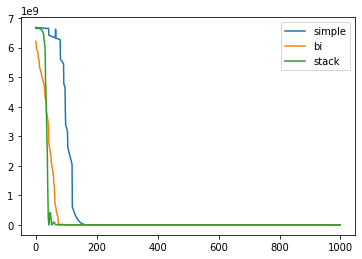

In [138]:
#PLOT MSE from the 3 graphs
pyplot.plot(history.history['mse'],label='simple')
pyplot.plot(bihistory.history['mse'],label='bi')
pyplot.plot(shistory.history['mse'],label='stack')
pyplot.legend()

### Compare Activations

In [188]:
# Simple LSTM - RELU Activation
model = Sequential()
model.add(LSTM(m, activation='relu', input_shape=(fib_look, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',metrics=['mse'])
history = model.fit(X_train, y_train, epochs=1000, validation_split=0.2, verbose=0)

#try on prediction
print(X_test)
print("Prediction: " + str(np.squeeze(model.predict(X_test))))
print("Actual: " + str(y_test))

[[[ 8]
  [13]]

 [[13]
  [21]]

 [[21]
  [34]]]
Prediction: [24.752184 40.32032  63.249104]
Actual: [21 34 55]


In [160]:
# Simple LSTM - Sigmoid Activation
model2 = Sequential()
model2.add(LSTM(m, activation='sigmoid', input_shape=(fib_look, 1)))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mse',metrics=['mse'])
history2 = model2.fit(X_train, y_train, epochs=1000, validation_split=0.2, verbose=0)

#try on prediction
print(X_test)
print("Prediction: " + str(np.squeeze(model2.predict(X_test))))
print("Actual: " + str(y_test))

[[[ 8]
  [13]]

 [[13]
  [21]]

 [[21]
  [34]]]
Prediction: [13.237977 16.261187 19.617468]
Actual: [21 34 55]


In [161]:
# Simple LSTM - Linear Activation
model3 = Sequential()
model3.add(LSTM(m, activation='linear', input_shape=(fib_look, 1)))
model3.add(Dense(1))
model3.compile(optimizer='adam', loss='mse',metrics=['mse'])
history3 = model3.fit(X_train, y_train, epochs=1000, validation_split=0.2, verbose=0)

#try on prediction
print(X_test)
print("Prediction: " + str(np.squeeze(model3.predict(X_test))))
print("Actual: " + str(y_test))

[[[ 8]
  [13]]

 [[13]
  [21]]

 [[21]
  [34]]]
Prediction: [24.58591  39.834045 61.070248]
Actual: [21 34 55]


In [168]:
# Simple LSTM - TANH Activation
model4 = Sequential()
model4.add(LSTM(m, activation='tanh', input_shape=(fib_look, 1)))
model4.add(Dense(1))
model4.compile(optimizer='adam', loss='mse',metrics=['mse'])
history4 = model4.fit(X_train, y_train, epochs=1000, validation_split=0.2, verbose=0)

#try on prediction
print(X_test)
print("Prediction: " + str(np.squeeze(model4.predict(X_test))))
print("Actual: " + str(y_test))

[[[ 8]
  [13]]

 [[13]
  [21]]

 [[21]
  [34]]]
Prediction: [20.892284 26.976177 30.669159]
Actual: [21 34 55]


In [187]:
# Simple LSTM - Softplus Activation
model5 = Sequential()
model5.add(LSTM(m, activation='softplus', input_shape=(fib_look, 1)))
model5.add(Dense(1))
model5.compile(optimizer='adam', loss='mse',metrics=['mse'])
history5 = model5.fit(X_train, y_train, epochs=1000, validation_split=0.2, verbose=0)

#try on prediction
print(X_test)
print("Prediction: " + str(np.squeeze(model5.predict(X_test))))
print("Actual: " + str(y_test))

[[[ 8]
  [13]]

 [[13]
  [21]]

 [[21]
  [34]]]
Prediction: [21.79715  36.129433 59.31515 ]
Actual: [21 34 55]


In [169]:
# Simple LSTM - exponential Activation
model6 = Sequential()
model6.add(LSTM(m, activation='exponential', input_shape=(fib_look, 1)))
model6.add(Dense(1))
model6.compile(optimizer='adam', loss='mse',metrics=['mse'])
history6 = model6.fit(X_train, y_train, epochs=1000, validation_split=0.2, verbose=0)

#try on prediction
print(X_test)
print("Prediction: " + str(np.squeeze(model6.predict(X_test))))
print("Actual: " + str(y_test))

[[[ 8]
  [13]]

 [[13]
  [21]]

 [[21]
  [34]]]
Prediction: [nan nan nan]
Actual: [21 34 55]


In [170]:
# Simple LSTM - ELU Activation
model7 = Sequential()
model7.add(LSTM(m, activation='elu', input_shape=(fib_look, 1)))
model7.add(Dense(1))
model7.compile(optimizer='adam', loss='mse',metrics=['mse'])
history7 = model7.fit(X_train, y_train, epochs=1000, validation_split=0.2, verbose=0)

#try on prediction
print(X_test)
print("Prediction: " + str(np.squeeze(model7.predict(X_test))))
print("Actual: " + str(y_test))

[[[ 8]
  [13]]

 [[13]
  [21]]

 [[21]
  [34]]]
Prediction: [23.138958 38.27629  61.144516]
Actual: [21 34 55]


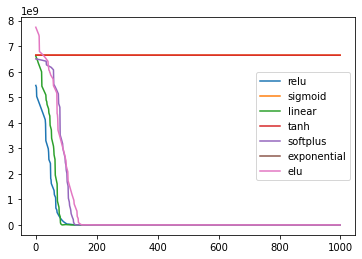

In [189]:
#compare all of them together
#PLOT MSE from the 7 graphs
pyplot.plot(history.history['mse'],label='relu')
pyplot.plot(history2.history['mse'],label='sigmoid')
pyplot.plot(history3.history['mse'],label='linear')
pyplot.plot(history4.history['mse'],label='tanh')
pyplot.plot(history5.history['mse'],label='softplus')
pyplot.plot(history6.history['mse'],label='exponential')
pyplot.plot(history7.history['mse'],label='elu')
pyplot.legend()

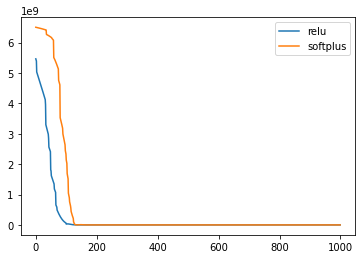

In [190]:
#print original and best
pyplot.plot(history.history['mse'],label='relu')
pyplot.plot(history5.history['mse'],label='softplus')
pyplot.legend()

## Learn from one example

The bot needs to be able to approximate a recursive function that changes from sequence to sequence. Therefore, we need to come up with a network capable of learning and validating itself from one example

### Recursive (Fibonacci)

In [185]:
#length of input sequence is 4 numbers, guess the 5th
print(X_train[:2])
print(X_train[2])
print(y_train[2])

[[[ 987]
  [1597]]

 [[1597]
  [2584]]]
[[2584]
 [4181]]
6765


[[[4181]
  [6765]]]
Prediction: 10920.7295
Actual: 10946


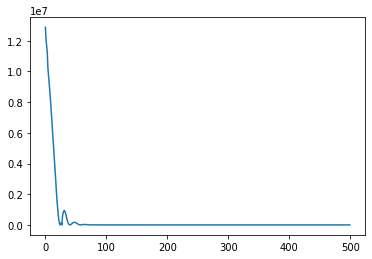

In [243]:
# Simple LSTM - softplus Activation
fib_model = Sequential()
fib_model.add(LSTM(50, activation='softplus', input_shape=(fib_look, 1)))
fib_model.add(Dense(1))
adam = keras.optimizers.Adam(lr=0.01)
fib_model.compile(optimizer=adam, loss='mse',metrics=['mse'])
fib_history = fib_model.fit([X_train[:2]], [y_train[:2]], epochs=500, validation_split=0.0, verbose=0)

#predict on unseen
xt = np.expand_dims(X_train[3],0)
print(xt)
print("Prediction: " + str(np.squeeze(fib_model.predict(xt))))
print("Actual: " + str(y_train[3]))

#plot error
pyplot.plot(fib_history.history['mse'])

### Index

In [206]:
#make dataset (input => index of number, output => value)
# function: A_n = (2n-1)*2n
ind_train = [[[1]],[[2]],[[3]]]     
ans_train = [[[2]],[[12]],[[30]]]
ind_test = [[[4]]]
ans_test = [[[56]]]

[[[4]]]
Prediction: 53.35866
Actual: [[[56]]]


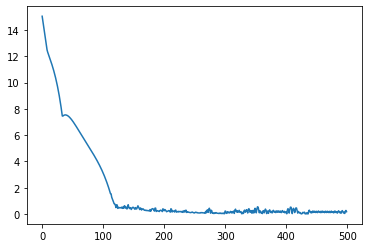

In [244]:
# Simple LSTM - softplus Activation
index_model = Sequential()
index_model.add(LSTM(50, activation='softplus', input_shape=(1, 1)))
index_model.add(Dense(1))
adam = keras.optimizers.Adam(lr=0.01)
index_model.compile(optimizer=adam, loss='mae',metrics=['mae'])
index_history = index_model.fit(ind_train, ans_train, epochs=500, validation_split=0.0, verbose=0)

#predict on unseen
print(ind_test)
print("Prediction: " + str(np.squeeze(index_model.predict(ind_test))))
print("Actual: " + str(ans_test))

#plot error
pyplot.plot(index_history.history['mae'])

### Recursive and index hybrid

In [224]:
#remember format of fibonacci data
print(X_train.shape)
print(y_train.shape)

(30, 2, 1)
(30,)


In [236]:
#make dataset (input => [value (n), index of number], output => value (n+1))
# function: A_{n+1} = 2^{5-n} - A_n
n_train = [[[7],[1]],[[9],[2]],[[-1],[3]]]     
nplus_train = [[[9]],[[-1]],[[5]]]
n_test = [[[5],[4]]]
nplus_test = [[[-3]]]

[[[5], [4]]]
Prediction: -1.8089914
Actual: [[[-3]]]


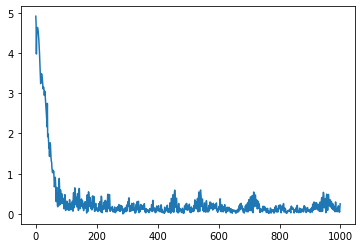

In [253]:
# Stacked LSTM - softplus Activation
hybrid_model = Sequential()
hybrid_model.add(LSTM(30, activation='softplus', input_shape=(2, 1)))
hybrid_model.add(Dense(1))
adam = keras.optimizers.Adam(lr=0.1)
hybrid_model.compile(optimizer=adam, loss='mae',metrics=['mae'])
hybrid_history = hybrid_model.fit(n_train, nplus_train, epochs=1000, validation_split=0.0, verbose=0)

#predict on unseen
print(n_test)
print("Prediction: " + str(np.squeeze(hybrid_model.predict(n_test))))
print("Actual: " + str(nplus_test))

#plot error
pyplot.plot(hybrid_history.history['mae'])

#### Note: Needs to have better accuracy (-1.8 is too close to -1 (a possible answer choice) rather than -3 (the actual answer)